# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Templates-(??-??-??)" data-toc-modified-id="Templates-(??-??-??)-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Templates (??-??-??)</a></div><div class="lev2 toc-item"><a href="#Goals" data-toc-modified-id="Goals-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Goals</a></div><div class="lev2 toc-item"><a href="#Summary" data-toc-modified-id="Summary-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Summary</a></div><div class="lev1 toc-item"><a href="#Preliminaries" data-toc-modified-id="Preliminaries-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Preliminaries</a></div><div class="lev2 toc-item"><a href="#Globals-and-Imports" data-toc-modified-id="Globals-and-Imports-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Globals and Imports</a></div><div class="lev2 toc-item"><a href="#Set-Matplotlib-defaults" data-toc-modified-id="Set-Matplotlib-defaults-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Set Matplotlib defaults</a></div><div class="lev2 toc-item"><a href="#Function-Definitions" data-toc-modified-id="Function-Definitions-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Function Definitions</a></div><div class="lev3 toc-item"><a href="#Atom-Analysis" data-toc-modified-id="Atom-Analysis-2.3.1"><span class="toc-item-num">2.3.1&nbsp;&nbsp;</span>Atom Analysis</a></div><div class="lev3 toc-item"><a href="#Fitting-Functions" data-toc-modified-id="Fitting-Functions-2.3.2"><span class="toc-item-num">2.3.2&nbsp;&nbsp;</span>Fitting Functions</a></div><div class="lev3 toc-item"><a href="#Import-Data-Function" data-toc-modified-id="Import-Data-Function-2.3.3"><span class="toc-item-num">2.3.3&nbsp;&nbsp;</span>Import Data Function</a></div><div class="lev3 toc-item"><a href="#Standard-Plots" data-toc-modified-id="Standard-Plots-2.3.4"><span class="toc-item-num">2.3.4&nbsp;&nbsp;</span>Standard Plots</a></div><div class="lev4 toc-item"><a href="#standardSurvivalPlot(data,-locs)" data-toc-modified-id="standardSurvivalPlot(data,-locs)-2.3.4.1"><span class="toc-item-num">2.3.4.1&nbsp;&nbsp;</span>standardSurvivalPlot(data, locs)</a></div><div class="lev4 toc-item"><a href="#standardTunnelingPlot(data)" data-toc-modified-id="standardTunnelingPlot(data)-2.3.4.2"><span class="toc-item-num">2.3.4.2&nbsp;&nbsp;</span>standardTunnelingPlot(data)</a></div><div class="lev3 toc-item"><a href="#Standard-Analysis" data-toc-modified-id="Standard-Analysis-2.3.5"><span class="toc-item-num">2.3.5&nbsp;&nbsp;</span>Standard Analysis</a></div><div class="lev4 toc-item"><a href="#standardSurvivalAnalysis(data)" data-toc-modified-id="standardSurvivalAnalysis(data)-2.3.5.1"><span class="toc-item-num">2.3.5.1&nbsp;&nbsp;</span>standardSurvivalAnalysis(data)</a></div><div class="lev4 toc-item"><a href="#standardTunnelingAnalysis(data)" data-toc-modified-id="standardTunnelingAnalysis(data)-2.3.5.2"><span class="toc-item-num">2.3.5.2&nbsp;&nbsp;</span>standardTunnelingAnalysis(data)</a></div><div class="lev3 toc-item"><a href="#Probe-Analysis" data-toc-modified-id="Probe-Analysis-2.3.6"><span class="toc-item-num">2.3.6&nbsp;&nbsp;</span>Probe Analysis</a></div><div class="lev4 toc-item"><a href="#probeSurvivalAnalysis(data)" data-toc-modified-id="probeSurvivalAnalysis(data)-2.3.6.1"><span class="toc-item-num">2.3.6.1&nbsp;&nbsp;</span>probeSurvivalAnalysis(data)</a></div><div class="lev2 toc-item"><a href="#Markdown-Reminders" data-toc-modified-id="Markdown-Reminders-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Markdown Reminders</a></div><div class="lev2 toc-item"><a href="#Usage-Notes" data-toc-modified-id="Usage-Notes-2.5"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>Usage Notes</a></div><div class="lev1 toc-item"><a href="#Generic-Single-Atom-Data-Analysis" data-toc-modified-id="Generic-Single-Atom-Data-Analysis-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Generic Single-Atom Data Analysis</a></div><div class="lev2 toc-item"><a href="#Generic-No-Fit" data-toc-modified-id="Generic-No-Fit-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Generic No-Fit</a></div><div class="lev2 toc-item"><a href="#Generic-Quadradic-Fit" data-toc-modified-id="Generic-Quadradic-Fit-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Generic Quadradic Fit</a></div><div class="lev2 toc-item"><a href="#Generic-$\text{sinc}^2\{x\}$-Fit" data-toc-modified-id="Generic-$\text{sinc}^2\{x\}$-Fit-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Generic <span class="MathJax_Preview" style="color: inherit;"></span><span tabindex="0" class="MathJax" id="MathJax-Element-2-Frame" role="presentation" style="position: relative;" data-mathml='<math xmlns="http://www.w3.org/1998/Math/MathML"><msup><mtext>sinc</mtext><mn>2</mn></msup><mo fence="false" stretchy="false">{</mo><mi>x</mi><mo fence="false" stretchy="false">}</mo></math>'><nobr aria-hidden="true"><span class="math" id="MathJax-Span-6" role="math" style="width: 4.14em; display: inline-block;"><span style="width: 3.44em; height: 0px; font-size: 120%; display: inline-block; position: relative;"><span style="left: 0em; top: -2.5em; position: absolute; clip: rect(1.49em, 1003.34em, 2.79em, -1000em);"><span class="mrow" id="MathJax-Span-7"><span class="msubsup" id="MathJax-Span-8"><span style="width: 2.04em; height: 0px; display: inline-block; position: relative;"><span style="left: 0em; top: -4.01em; position: absolute; clip: rect(3.21em, 1001.58em, 4.13em, -1000em);"><span class="mtext" id="MathJax-Span-9" style="font-family: STIXMathJax_Main;">sinc</span><span style="width: 0px; height: 4.01em; display: inline-block;"></span></span><span style="left: 1.61em; top: -4.42em; position: absolute;"><span class="mn" id="MathJax-Span-10" style="font-family: STIXMathJax_Main; font-size: 70.7%;">2</span><span style="width: 0px; height: 4.01em; display: inline-block;"></span></span></span></span><span class="mo" id="MathJax-Span-11" style="font-family: STIXMathJax_Main;">{</span><span class="mi" id="MathJax-Span-12" style="font-family: STIXMathJax_Main; font-style: italic;">x<span style="width: 0em; height: 1px; overflow: hidden; display: inline-block;"></span></span><span class="mo" id="MathJax-Span-13" style="font-family: STIXMathJax_Main;">}</span></span><span style="width: 0px; height: 2.5em; display: inline-block;"></span></span></span><span style="width: 0px; height: 1.37em; overflow: hidden; vertical-align: -0.26em; border-left-color: currentColor; border-left-width: 0px; border-left-style: solid; display: inline-block;"></span></span></nobr><span class="MJX_Assistive_MathML" role="presentation"><math xmlns="http://www.w3.org/1998/Math/MathML"><msup><mtext>sinc</mtext><mn>2</mn></msup><mo stretchy="false" fence="false">{</mo><mi>x</mi><mo stretchy="false" fence="false">}</mo></math></span></span><script id="MathJax-Element-2" type="math/tex">\text{sinc}^2\{x\}</script> Fit</a></div><div class="lev2 toc-item"><a href="#Generic-Gaussian-Fit" data-toc-modified-id="Generic-Gaussian-Fit-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Generic Gaussian Fit</a></div><div class="lev2 toc-item"><a href="#Generic-Double-Gaussian-Fit" data-toc-modified-id="Generic-Double-Gaussian-Fit-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>Generic Double-Gaussian Fit</a></div><div class="lev2 toc-item"><a href="#Generic-Triple-Gaussian-Fit" data-toc-modified-id="Generic-Triple-Gaussian-Fit-3.6"><span class="toc-item-num">3.6&nbsp;&nbsp;</span>Generic Triple-Gaussian Fit</a></div><div class="lev2 toc-item"><a href="#Generic-Lorentzian-Fit" data-toc-modified-id="Generic-Lorentzian-Fit-3.7"><span class="toc-item-num">3.7&nbsp;&nbsp;</span>Generic Lorentzian Fit</a></div><div class="lev2 toc-item"><a href="#Generic-Cos-Fit" data-toc-modified-id="Generic-Cos-Fit-3.8"><span class="toc-item-num">3.8&nbsp;&nbsp;</span>Generic Cos Fit</a></div><div class="lev1 toc-item"><a href="#Specific-Multi-Atom-Analysis" data-toc-modified-id="Specific-Multi-Atom-Analysis-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Specific Multi-Atom Analysis</a></div><div class="lev2 toc-item"><a href="#Tunneling-Bias-Scan" data-toc-modified-id="Tunneling-Bias-Scan-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Tunneling Bias Scan</a></div><div class="lev2 toc-item"><a href="#Tunneling-Time-Trace" data-toc-modified-id="Tunneling-Time-Trace-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Tunneling Time Trace</a></div><div class="lev1 toc-item"><a href="#Specific-Single-Atom-Data-Analysis" data-toc-modified-id="Specific-Single-Atom-Data-Analysis-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Specific Single-Atom Data Analysis</a></div><div class="lev2 toc-item"><a href="#Carrier-Calibration" data-toc-modified-id="Carrier-Calibration-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Carrier Calibration</a></div><div class="lev2 toc-item"><a href="#Microwave-Calibration" data-toc-modified-id="Microwave-Calibration-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Microwave Calibration</a></div><div class="lev2 toc-item"><a href="#Sideband-Spectroscopy" data-toc-modified-id="Sideband-Spectroscopy-5.3"><span class="toc-item-num">5.3&nbsp;&nbsp;</span>Sideband Spectroscopy</a></div><div class="lev2 toc-item"><a href="#Ramsey-Time-Trace" data-toc-modified-id="Ramsey-Time-Trace-5.4"><span class="toc-item-num">5.4&nbsp;&nbsp;</span>Ramsey Time Trace</a></div><div class="lev2 toc-item"><a href="#Piezo-Scan" data-toc-modified-id="Piezo-Scan-5.5"><span class="toc-item-num">5.5&nbsp;&nbsp;</span>Piezo Scan</a></div>

# Templates (??-??-??)

## Goals

- The main point of this ipynb is to get working versions of the import function working and to get some generic imports working as well.

## Summary

Still a work in progress.

# Preliminaries

## Globals and Imports

In [12]:
date = "160911"  
directory = "//Andor/share/Data and documents/Data repository/" + date + "/"
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.optimize import curve_fit as fit
from matplotlib.ticker import ScalarFormatter
from matplotlib import gridspec
from collections import OrderedDict as dic
%matplotlib inline

## Set Matplotlib defaults

In [13]:
# set matplotlib plot defaults :D
# These values are nice for a dark theme.
mpl.rcParams['text.color'] = '#ffffff'
mpl.rcParams['figure.edgecolor'] = '#ffffff'
mpl.rcParams['xtick.color'] = '#ffffff'
mpl.rcParams['ytick.color'] = '#ffffff'
mpl.rcParams['figure.facecolor'] = '#000000'
mpl.rcParams['axes.facecolor'] = '#0a0a0a'
mpl.rcParams['figure.figsize'] = (18.0, 8.0)
mpl.rcParams['axes.labelcolor'] = '#ffffff'
mpl.rcParams['grid.color'] = '#aaaaff'
mpl.rcParams['axes.edgecolor'] = '#ffffff'
mpl.rcParams['legend.facecolor'] = '#0a0a0a'
mpl.rcParams['axes.grid'] = True
mpl.rcParams['axes.formatter.useoffset'] = False

## Function Definitions

### Atom Analysis

In [14]:
def atomAnalysis(date, runNumber, analysisLocations, picturesPerExperiment, repetitions):
    """
    - This function is a carbon-copy of the function used by the camera code to do the first-step analysis. 
    - It is here to use in case the analysis via the camera code fails. You can utilize this function, or modify
        it and it's guess for the gaussian peaks.
    :param date: The date string, format 'YYMMDD'
    :param runNumber: This identifies 
    :param analysisLocations:
    :param picturesPerExperiment:
    :param repetitions:
    :return:
    """
    import numpy as np
    from astropy.io import fits
    from collections import OrderedDict as dic
    from dataAnalysisFunctions import (normalizeData, binData, guessGaussianPeaks, fitDoubleGaussian,
                                       calculateAtomThreshold, getAtomData)
    baseData = dic()
    baseData['Dictionary Key'] = ''
    baseData['Date'] = date
    baseData['Run Number'] = runNumber
    baseData['Repetitions'] = repetitions
    baseData['Pictures Per Repetition'] = picturesPerExperiment
    # paths for files
    # dataRepositoryPath = "C:\\Users\\Mark\\Documents\\Quantum Gas Assembly Control\\Data\\Camera Data\\"
    dataRepositoryPath = "\\\\andor\\share\\Data and documents\\Data repository\\"
    todaysDataPath = dataRepositoryPath + date + "\\Raw Data\\data_" + str(runNumber) + ".fits"
    keyPath = dataRepositoryPath + date + "\\Raw Data\\key_" + str(runNumber) + ".txt"
    # Load Key
    baseData['Key'] = np.array([])
    with open(keyPath) as keyFile:
        for line in keyFile:
            baseData['Key'] = np.append(baseData['Key'], float(line.strip('\n')))
    # Load Fits File & Get Dimensions
    # Get the array from the fits file. That's all I care about.
    fitsInfo = fits.open(todaysDataPath, "append")
    rawData = fitsInfo[0].data
    fitsInfo.close()
    # ##########################################################################
    #
    #       Loop for each atom to analyze
    #
    numberAtomsToAnalyze = np.array(analysisLocations).shape[0]
    atomLocationList = '#'
    baseData['Analysis Location List'] = ''
    for atomInc in range(0, int(numberAtomsToAnalyze / 2)):
        print('Analyzing atom #' + str(atomInc))
        tempData = dic()
        tempData['Dictionary Key'] = ''
        tempData['Atom Location'] = np.array([analysisLocations[2 * atomInc], analysisLocations[2 * atomInc + 1]])
        # My function here.
        tempData['Camera Signal'] = normalizeData(rawData, tempData['Atom Location'])
        # ### Figure out the threshold
        # Get Binned Data
        binCenters, binnedData = binData(5, tempData['Camera Signal'])
        # Make educated Guesses for Peaks
        guess1, guess2 = guessGaussianPeaks(binCenters, binnedData)
        # Calculate Atom Threshold
        # define the fitting function
        guess = np.array([max(binnedData), guess1, 30, max(binnedData), guess2, 30])
        gaussianFitVals = fitDoubleGaussian(binCenters, binnedData, guess)
        tempData['Threshold'], tempData['Threshold Fidelity'] = calculateAtomThreshold(gaussianFitVals)
        # Get Data in final form for exporting
        tempData['Atom Data'] = getAtomData(tempData['Camera Signal'], tempData['Threshold'])
        tempData['Dictionary Key'] = list(tempData.keys())
        atomLocationList += str(analysisLocations[2 * atomInc]) + ", " + str(analysisLocations[2 * atomInc + 1])
        baseData[str(analysisLocations[2 * atomInc]) + ", " + str(analysisLocations[2 * atomInc + 1])] = tempData
        atomLocationList += '#'
    baseData['Analysis Location List'] = atomLocationList
    print('Prepping Data')
    outputName = dataRepositoryPath + baseData['Date'] + "\\" + "run_" + str(baseData['Run Number']) + "_data.csv"
    baseData['Dictionary Key'] = list(baseData.keys())
    csvText = ''
    for keyHeader, value in baseData.items():
        if isinstance(value, str):
            # don't iterate through the string, just add it.
            csvText += '\n:' + keyHeader + ': ' + str(value)
            continue
        if isinstance(value, dict):
            # iterate through that! Assume no nested dictionaries.
            csvText += '\n:[' + keyHeader + ']:'
            for subHeader, subValue in value.items():
                if subHeader == "Raw Data":
                    # want to put this on last.
                    continue
                if isinstance(subValue, str):
                    # don't iterate through the string, just add it.
                    csvText += '\n\t;' + subHeader + '; ' + str(subValue)
                    continue
                try:
                    csvText += '\n\t;' + subHeader + '; ' + ", ".join(str(x) for x in subValue)
                except TypeError:
                    # catch integers.
                    csvText += '\n\t;' + subHeader + '; ' + str(subValue)
            continue
        try:
            csvText += '\n:' + keyHeader + ': ' + ", ".join(str(x) for x in value)
        except TypeError:
            # catch integers.
            csvText += '\n:' + keyHeader + ': ' + str(value)
    print("Writing Data...")
    with open(outputName, "w") as record_file:
        record_file.write(csvText)
    print('Complete!')
    return "Finished"

### Fitting Functions

In [15]:
# Fits 
def quadratic(x,a,b,x0):
    # This assumes downward facing. Best to write another function for upward facing if need be, I think.
    if a < 0:
        return 10**10
    if b > 0:
        return 10**10
    return a + b*(x-x0)**2


def gaussian(x, A1, x01, sig1, offset):
    if (offset < 0):
        return 10**10
    return offset + A1 * np.exp(-(x-x01)**2/(2*sig1**2))


def doubleGaussian(x, A1, x01, sig1, A2, x02, sig2, offset):
    if (A1 < 0 or A2 < 0):
        # Penalize negative fits.
        return 10**10
    if (offset < 0):
        return 10**10
    return offset + A1 * np.exp(-(x-x01)**2/(2*sig1**2)) + A2 * np.exp(-(x-x02)**2/(2*sig2**2))


def tripleGaussian(x, A1, x01, sig1, A2, x02, sig2, A3, x03, sig3, offset ):
    if (A1 < 0 or A2 < 0 or A3 < 0):
        # Penalize negative fits.
        return 10**10
    if (offset < 0):
        return 10**10
    return (offset + A1 * np.exp(-(x-x01)**2/(2*sig1**2)) + A2 * np.exp(-(x-x02)**2/(2*sig2**2)) 
            + A3 * np.exp(-(x-x03)**2/(2*sig3**2)))        


def decayingCos(x, A, tau, f, phi, offset):
    # Just for sanity. Keep some numbers positive.
    if (A < 0):
        return x * 10**10
    if (phi < 0):
        return x * 10**10
    if (offset < 0):
        return x * 10**10
    # no growing fits.
    if (tau > 0):
        return x * 10**10
    return offset + (1 - A/2 * np.exp(-x/tau) * np.cos(2 * np.pi * f * x + phi))


def sinc2(x, A, center, scale, offset):
    """
    The 2 here referes to squared!
    """
    if (offset < 0):
        return x * 10**10
    if (A < 0):
        return x * 10**10
    return (A * np.sinc((x - center)/scale)**2 + offset)


def lorentzian(x, A, center, width, offset):
    if (offset < 0):
        return x * 10**10
    if (A < 0):
        return x * 10**10
    return (A /((x - center)**2 + (width/2)**2))


def poissonian(x, k, weight):    
    """
    This function calculates p_k{x} = weight * e^(-k) * k^x / x!.
    :param x: argument of the poissonian
    :param k: order or (approximate) mean of the poissonian.
    :param weight: a weight factor, related to the maximum data this is supposed to be fitted to, but typically over-
    weighted for the purposes of this function.
    :return: the poissonian evaluated at x given the parametes.
    """
    import numpy as np
    term = 1
    # calculate the term k^x / x!. Can't do this directly, x! is too large.
    for n in range(0, int(x)):
        term *= k / (x - n)
    return np.exp(-k) * term * weight


In [16]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

### Import Data Function

In [82]:
def importData(date, runNumber):
    from ast import literal_eval as make_tuple
    """
    This function imports the data created by my first-step python code.
    :param date: the date in YYMMDD format so that the code knows where to look for the data.
    :param name: the name of the compiled data file, minus _run?? (e.g. it's standardized for carrier calibrations
    :param runNumber: The run number.
    :return: returns an OrderedDictionary object from the collections library that contains all the information about
             a run.
    """
    from collections import OrderedDict as dic
    data = dic()
    #dataAddress = 'C:/Users/Mark/Documents/Quantum Gas Assembly Control/Data/Camera Data/'
    dataAddress = '//andor/share/Data and documents/Data repository/'
    with open(dataAddress + str(date) + '/run_' + str(runNumber) + '_data.csv') as myfile:
        fileText = myfile.read().replace('\n', '')
        fileText = fileText.replace('\r', '`')
        rows = []
        for row in fileText.split(':X:'):
            rows.append(row.replace('\t', ''))
        # there's a blank row in there by default.
        del rows[0]
        for itemInc in range(0, len(rows), 2):
            if (rows[itemInc] == 'Vertical NIAWG Script' or rows[itemInc] == 'Horizontal NIAWG Script' 
                or rows[itemInc] == 'Intensity Script' or rows[itemInc] == 'NIAWG Parameters'):
                data[rows[itemInc]] = str(rows[itemInc + 1].replace('`','\n'))
            # Check if it's a sub-item. Subitems have ';' around them instead of ':'
            elif (rows[itemInc + 1].find(';')) != -1:
                itemData = dic()
                subrows = []
                for subrow in rows[itemInc + 1].split(';'):
                    subrows.append(subrow)
                del subrows[0]
                for subitem in range(0, len(subrows), 2):
                    try:
                        itemData[subrows[subitem]] = [float(item) for item in (subrows[subitem + 1].split(','))]
                    except:
                        itemData[subrows[subitem]] = subrows[subitem + 1].split(',')
                data[rows[itemInc]] = itemData
            # Look for the atom locations entry. It must be handled separately.
            elif (rows[itemInc + 1].find('#')) != -1:
                rows[itemInc + 1] = rows[itemInc + 1][2:]
                data[rows[itemInc]] = [make_tuple('[' + str(item) + ']') for item in (rows[itemInc + 1].split('#'))]
            else:
                # normal stuff.
                try:
                    data[rows[itemInc]] = [float(item) for item in (rows[itemInc + 1].split(','))]                    
                    data[rows[itemInc]] = [float(item) for item in (rows[itemInc + 1].split(','))]
                    if len(data[rows[itemInc]]) == 1:
                        data[rows[itemInc]] = data[rows[itemInc]][0]
                except:
                    data[rows[itemInc]] = rows[itemInc + 1].split(',')
    return data

In [87]:
data = importData(date, 1)
print(data['Dictionary Key'])

[' Dictionary Key', ' Date', ' Run Number', ' Warnings', ' Repetitions', ' Pictures Per Repetition', ' Horizontal NIAWG Script', ' Vertical NIAWG Script', ' Intensity Script', ' NIAWG Parameters', ' Key', ' Analysis Location List', ' 6', ' 0']


### Standard Plots

#### standardSurvivalPlot(data, locs)

In [18]:
def standardSurvivalPlot(data, locs):
    """
    This function creates a standard plot. It plots survival data, survival fits, data counts, and loading probabilities.
    It does all of this in a 12x16 gridspec and leaves one corner open for specializing a given plot.
    """
    # Make colormap. really only need len(locs) + 1 rgbs, but adding an extra makes the spacing of the colors
    # on this colormap more sensible.
    cmapRGB = mpl.cm.get_cmap('gist_rainbow', len(locs) + 2)
    colormap = []
    for colorInc in range(cmapRGB.N):
        colormap.append(mpl.colors.rgb2hex(cmapRGB(colorInc)[:3]))
    # Setup grid
    grid1 = mpl.gridspec.GridSpec(12, 16)
    grid1.update(left=0.05, right=0.95, wspace=1.2, hspace=1000)
    gridLeft = mpl.gridspec.GridSpec(12, 16)
    gridLeft.update(left=0.001, right=0.95, hspace=1000)
    gridRight = mpl.gridspec.GridSpec(12, 16)
    gridRight.update(left=0.2, right=0.946, wspace=0, hspace=1000)
    # ### Main Plot
    mainPlot = plt.subplot(grid1[:, :12])
    # Plot Atoms
    for atomInc in range(0, len(locs)):
        mainPlot.errorbar(data['Key'], data[locs[atomInc]]['Survival Averages'], yerr=data[locs[atomInc]]['Survival Errors'],
                          ls='', marker='o', color=colormap[atomInc], capsize=6, elinewidth=3)
        mainPlot.plot(data['xForFit'], data[locs[atomInc]]['fitData'], color=colormap[atomInc], label=locs[atomInc], 
                      linewidth=3)
    # Plot Average
    mainPlot.plot(data['xForFit'], data['[Correlation Averages]']['fitData'], color=colormap[len(locs)], 
                  label='Average', linewidth=3)                                       
    mainPlot.errorbar(data['Key'], data['[Correlation Averages]']['Total average single atom survival'], 
                      yerr=data['[Correlation Errors]']['Total average single atom survival'],
                      ls='', marker='o', color=colormap[len(locs)], capsize=6, elinewidth=3)
    mainPlot.set_ylim({-0.02, 1.01})
    mainPlot.set_xlim({min(data['Key']) - (max(data['Key']) - min(data['Key'])) / len(data['Key']), 
                      max(data['Key']) + (max(data['Key']) - min(data['Key'])) / len(data['Key'])})
    mainPlot.set_xticks(data['Key'])
    mainPlot.set_title("Survival Data", fontsize=30)
    mainPlot.set_ylabel("Survival Probability", fontsize=20)
    mainPlot.set_xlabel("Key Values", fontsize=20)
    mainPlot.legend(loc="upper center", bbox_to_anchor=(0.5,-0.1), fancybox=True, ncol=4)
    mainPlot.grid("on")
    # ### Capture Probabilities Plot
    capturePlot = plt.subplot(grid1[8:12, 12:16])
    for atomInc in range(len(locs)):
        capturePlot.plot(data['Key'], data[locs[atomInc]]['Loading Probabilities'], ls='', marker='o', 
                         color=colormap[atomInc])
        capturePlot.axhline(np.mean(data[locs[atomInc]]['Loading Probabilities']), color=colormap[atomInc])
    capturePlot.set_ylim({0, 1})
    capturePlot.set_xlim({min(data['Key']) - (max(data['Key']) - min(data['Key'])) / len(data['Key']), 
                      max(data['Key']) + (max(data['Key']) - min(data['Key'])) / len(data['Key'])})
    capturePlot.set_xlabel("Key Values")
    capturePlot.set_ylabel("Capture %")
    capturePlot.set_title("Capture Probabilities")
    capturePlot.grid("on")
    # ### Count Series Plot
    countDataPlot = plt.subplot(gridRight[4:8, 12:15])
    for atomInc in range(len(locs)):
        countDataPlot.plot(data[locs[atomInc]]['Data Counts'], color=colormap[atomInc], ls='', marker='.', markersize=1)
        countDataPlot.axhline(data[locs[atomInc]]['Threshold'], color=colormap[atomInc])
    countDataPlot.set_xlabel("Picture #")
    countDataPlot.set_ylabel("Camera Signal")
    countDataPlot.set_title("Camera Signal Over Time")
    countDataPlot.grid("on")
    ticksForVis = countDataPlot.xaxis.get_major_ticks()
    ticksForVis[-1].label1.set_visible(False)
    # Count Histogram Plot
    countHistPlot = plt.subplot(gridLeft[4:8, 15:16], sharey=countDataPlot)
    # countHistPlot = plt.subplot2grid((16, 16), (4, 15), rowspan=4, sharey=countDataPlot)
    for atomInc in range(len(locs)):
        countHistPlot.hist(data[locs[atomInc]]["Data Counts"], 50, color=colormap[atomInc], orientation='horizontal',
                           alpha=1/len(locs))
        countHistPlot.axhline(data[locs[atomInc]]["Threshold"], color=colormap[atomInc])
    ticks = countHistPlot.get_xticklabels()
    for tickInc in range(len(ticks)):
        ticks[tickInc].set_rotation(-45)
    plt.setp(countHistPlot.get_yticklabels(), visible=False)


#### standardTunnelingPlot(data)

In [19]:
def standardTunnelingPlot(data):
    # TODO
    pass

### Standard Analysis

#### standardSurvivalAnalysis(data)

In [20]:
def standardSurvivalAnalysis(data):
    """
    - This function ONLY assumes greater than 1 picture. If there are more than 2, it just checks the first and last
        Picture to determine survival. 
    - This function takes in the data structure to be modified. The data structure is modified so that every atom
        subsection in the data structure has 'Survival Averages', 'Survival Errors', and 'Loading Probailities' added 
        to that atom subsection of the data structure.
    """
    for loc in data['Analysis Location List']:
        loc = str(loc)
        if loc == '[]':
            continue
        import numpy as np
        # Take the previous data, which includes entries when there was no atom in the first picture, and convert it to
        # an array of just loaded and survived or loaded and died.    
        data[loc]['Survival Averages'] = np.array([])
        data[loc]['Loading Probabilities'] = np.array([])
        data[loc]['Survival Errors'] = np.array([])
        picturesPerVariation = data['Repetitions'] * int(data['Pictures Per Repetition'])
        for variationInc in range(int(len(data[loc]['Atom Data']) / picturesPerVariation)):
            survivalList = np.array([])
            for repetitionInc in range(int(data['Repetitions'])):
                firstPic = int(variationInc * picturesPerVariation + repetitionInc 
                               * data['Pictures Per Repetition'])
                lastPic = int(variationInc * picturesPerVariation 
                          + (repetitionInc + 1) * data['Pictures Per Repetition'] - 1)
                if data[loc]['Atom Data'][firstPic] == 0:
                    # Then no atom was loaded.
                    continue
                # Check the last picture in a given repetition:
                if data[loc]['Atom Data'][lastPic] == 1:
                    # Atom Survived
                    survivalList = np.append(survivalList, 1)
                elif data[loc]['Atom Data'][lastPic] == 0:
                    # Atom Did Not Survive
                    survivalList = np.append(survivalList, 0)
                else:
                    print('Atom Data not formatted as expected! Expected only 0 or 1, but found ' 
                          + str(data[loc]['Atom Data'][lastPic] == 1))
                    return
            if survivalList.size == 0:
                # catch the case where there's no relevant data, typically if laser becomes unlocked.
                survivalErrors = np.append(survivalErrors, 0)
                data[loc]['Loading Probabilities'] = np.append(data[loc]['Loading Probabilities'], 0)
                data[loc]['Survival Averages'] = np.append(data[loc]['Survival Averages'], 0)
            else:
                # normal case
                data[loc]['Survival Errors'] = np.append(data[loc]['Survival Errors'], 
                                                         np.std(survivalList)/np.sqrt(survivalList.size))
                data[loc]['Loading Probabilities'] = np.append(data[loc]['Loading Probabilities'], 
                                                               survivalList.size / data['Repetitions'])
                data[loc]['Survival Averages'] = np.append(data[loc]['Survival Averages'], 
                                                           np.average(survivalList))
        # Update the key for this atom.
        data[loc]['Dictionary Key'] = list(data[loc].keys())

#### standardTunnelingAnalysis(data)

In [21]:
def standardTunnelingAnalysis(data):
    # TODO!
    stuff

### Probe Analysis

#### probeSurvivalAnalysis(data)

In [22]:
def probeSurvivalAnalysis(data):
    # TODO!
    pass

## Markdown Reminders

Markdown | Table | Example
--- | :---: | ---:
*It* | `renders` | **nicely**
~~1~~ | 2 | 3

```str hello = 'world'
errBox("not an *error*")
return FALSE;```

> what is going
> on

---

- Lists
+ Are
* Fun  


***

1.  stuff
  * Unordered sub-list.
1000. Actual numbers don't matter, just that it's a number
+ I lied, just the first bullet for a given list determines the type.
  1. Ordered sub-list  
    hey.
    2. what?

___

html and links are also possible.

## Usage Notes

Current Base Key Strings (data['???']):  
- Key List
- Date
- Run Number
- Repetitions
- Pictures Per Experiment
- Key
- < Atom Locations >
- Correlation Averages
- Correlation Errors

Current Atom Key Strings (e.g. data['[3, 1]']['???'])
- Key List
- Survival Averages
- Survival Errors
- Loading Probabilities
- Atom Location
- Threshold
- Threshold Fidelity
- Atoms Data

Current Multi-Atom Key Strings (e.g. data['[Correlation Averages]']['???'])
- Load < 1-max >, atom < 0-max-1 > survived
- Load < 1-max >, < 0-max > atoms survived
- Load < 1-max >, average single atom survival
- Total average single atom survival

Similar for Multi-Atom Errors.

# Generic Single-Atom Data Analysis

## Generic No-Fit

In [9]:
# locals for convenience
filename = "Carrier_Calibration_Top_Vert" # shouldn't include run number.
data = importData(date, filename, 12) # stands for "data from run 11"
locs = ['[3, 1]', '[5, 1]']

if True: # All Fitting and Plotting Details 
    # ################ #########################
    # ### Plotting ### #########################
    # ################ #########################

    # Make colormap. really only need len(locs) + 1 rgbs, but adding an extra makes the spacing of the colors
    # on this colormap more sensible.
    cmapRGB = mpl.cm.get_cmap('gist_rainbow', len(locs) + 2)
    colormap = []
    for colorInc in range(cmapRGB.N):
        colormap.append(mpl.colors.rgb2hex(cmapRGB(colorInc)[:3]))
    # Setup grid
    grid1 = mpl.gridspec.GridSpec(12, 16)
    grid1.update(left=0.05, right=0.95, wspace=1.2, hspace=1000)
    gridLeft = mpl.gridspec.GridSpec(12, 16)
    gridLeft.update(left=0.001, right=0.95, hspace=1000)
    gridRight = mpl.gridspec.GridSpec(12, 16)
    gridRight.update(left=0.2, right=0.946, wspace=0, hspace=1000)
    # ### Main Plot
    mainPlot = plt.subplot(grid1[:, :12])
    # Plot Atoms
    for atomInc in range(0, len(locs)):
        mainPlot.errorbar(data['Key'], data[locs[atomInc]]['Survival Averages'], yerr=data[locs[atomInc]]['Survival Errors'],
                          ls='', marker='o', color=colormap[atomInc], capsize=6, elinewidth=3)
    # Plot Average                                     
    mainPlot.errorbar(data['Key'], data['[Correlation Averages]']['Total average single atom survival'], 
                      yerr=data['[Correlation Errors]']['Total average single atom survival'],
                      ls='', marker='o', color=colormap[len(locs)], capsize=6, elinewidth=3)
    mainPlot.set_ylim({-0.02, 1.01})
    mainPlot.set_xlim({min(data['Key']) - (max(data['Key']) - min(data['Key'])) / len(data['Key']), 
                      max(data['Key']) + (max(data['Key']) - min(data['Key'])) / len(data['Key'])})
    mainPlot.set_xticks(data['Key'])
    mainPlot.set_title("Survival Data", fontsize=30)
    mainPlot.set_ylabel("Survival Probability", fontsize=20)
    mainPlot.set_xlabel("Key Values", fontsize=20)
    mainPlot.legend(loc="upper center", bbox_to_anchor=(0.5,-0.1), fancybox=True, ncol=4)
    mainPlot.grid("on")
    # ### Capture Probabilities Plot
    capturePlot = plt.subplot(grid1[8:12, 12:16])
    for atomInc in range(len(locs)):
        capturePlot.plot(data['Key'], data[locs[atomInc]]['Loading Probabilities'], ls='', marker='o', 
                         color=colormap[atomInc])
        capturePlot.axhline(np.mean(data[locs[atomInc]]['Loading Probabilities']), color=colormap[atomInc])
    capturePlot.set_ylim({0, 1})
    capturePlot.set_xlim({min(data['Key']) - (max(data['Key']) - min(data['Key'])) / len(data['Key']), 
                      max(data['Key']) + (max(data['Key']) - min(data['Key'])) / len(data['Key'])})
    capturePlot.set_xlabel("Key Values")
    capturePlot.set_ylabel("Capture %")
    capturePlot.set_title("Capture Probabilities")
    capturePlot.grid("on")
    # ### Count Series Plot
    countDataPlot = plt.subplot(gridRight[4:8, 12:15])
    for atomInc in range(len(locs)):
        countDataPlot.plot(data[locs[atomInc]]['Data Counts'], color=colormap[atomInc], ls='', marker='.', markersize=1)
        countDataPlot.axhline(data[locs[atomInc]]['Threshold'], color=colormap[atomInc])
    countDataPlot.set_xlabel("Picture #")
    countDataPlot.set_ylabel("Camera Signal")
    countDataPlot.set_title("Camera Signal Over Time")
    countDataPlot.grid("on")
    ticksForVis = countDataPlot.xaxis.get_major_ticks()
    ticksForVis[-1].label1.set_visible(False)
    # Count Histogram Plot
    countHistPlot = plt.subplot(gridLeft[4:8, 15:16], sharey=countDataPlot)
    # countHistPlot = plt.subplot2grid((16, 16), (4, 15), rowspan=4, sharey=countDataPlot)
    for atomInc in range(len(locs)):
        countHistPlot.hist(data[locs[atomInc]]["Data Counts"], 50, color=colormap[atomInc], orientation='horizontal',
                           alpha=1/len(locs))
        countHistPlot.axhline(data[locs[atomInc]]["Threshold"], color=colormap[atomInc])
    ticks = countHistPlot.get_xticklabels()
    for tickInc in range(len(ticks)):
        ticks[tickInc].set_rotation(-45)
    plt.setp(countHistPlot.get_yticklabels(), visible=False)

    # ### info plot
    infoPlot = plt.subplot(grid1[0:4, 12:16])
    infoPlot.axis("off")
    infoPlot.text(0,0.1,"Repetitions: " + str(data['Repetitions']))
    infoPlot.text(0, 0.2, "Date: " + str(data['Date']));

C:\Users\Mark\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


## Generic Quadradic Fit

In [88]:
# locals for convenience
#filename = "Carrier_Calibration_Top_Vert" # shouldn't include run number.
data = importData(date, 1)
# Atom locations
locs = ['[3, 1]', '[5, 1]']

if True: # All Fitting and Plotting Details 
    # ####################
    # ### fit the data ###
    #
    data['xForFit'] = np.linspace(min(data['Key']), max(data['Key']), 1000)
    centerGuesses = []
    widthGuess = - 1 / np.std(data['Key']) # assumes downward facing.
    # Get all the atoms
    for atomInc in range(0, len(locs)):
        centerGuesses.append(data['Key'][data[locs[atomInc]]['Survival Averages'] \
                                         .index(max(data[locs[atomInc]]['Survival Averages']))])
        # def gaussian(x, A1, x01, sig1, offset)
        data[locs[atomInc]]['fitValues'], \
            data[locs[atomInc]]['covValues'] = fit(quadratic, data['Key'], data[locs[atomInc]]['Survival Averages'], 
                                                    p0=[0.95, widthGuess, centerGuesses[atomInc]])
        data[locs[atomInc]]['fitData'] = quadratic(data['xForFit'], *data[locs[atomInc]]['fitValues']);
    # fit the averaged data.
    avgCenterGuess = np.mean(centerGuesses)
    data['[Correlation Averages]']['fitValues'], data['[Correlation Averages]']['covValues'] \
        = fit(quadratic, data['Key'], data['[Correlation Averages]']['Total average single atom survival'],
              p0=[0.95, widthGuess, avgCenterGuess])
    data['[Correlation Averages]']['fitData'] = quadratic(data['xForFit'], *data['[Correlation Averages]']['fitValues'])                                     

    # ### 
    # Create most of the standard plot info.
    standardSurvivalPlot(data, locs)

    # Add the info plot
    grid1 = mpl.gridspec.GridSpec(12, 16)
    grid1.update(left=0.05, right=0.95, wspace=1.2, hspace=1000)
    infoPlot = plt.subplot(grid1[0:4, 12:16])
    infoPlot.axis("off")
    infoPlot.text(0,0.1,"Repetitions: " + str(data['Repetitions']))
    infoPlot.text(0, 0.2, "Date: " + str(data['Date']))
    for atomInc in range(len(locs)):
        infoPlot.text(0,0.3 + 0.1 * atomInc,'Well ' + locs[atomInc] + ' Center = ' + "{:.7f}".format(data[locs[atomInc]]['fitValues'][1]) + "[" 
                      + "{:.0f}".format(10**7*np.sqrt(data[locs[atomInc]]['covValues'][1][1])) + "] GHz", fontweight='bold')
    infoPlot.text(0,0.3 + 0.1 * len(locs),'Average Center = ' + "{:.7f}".format(data['[Correlation Averages]']['fitValues'][1]) + "[" 
                  + "{:.0f}".format(10**7 * np.sqrt(data['[Correlation Averages]']['covValues'][1][1])) + "] GHz", fontweight='bold');


KeyError: '[3, 1]'

## Generic $\text{sinc}^2\{x\}$ Fit

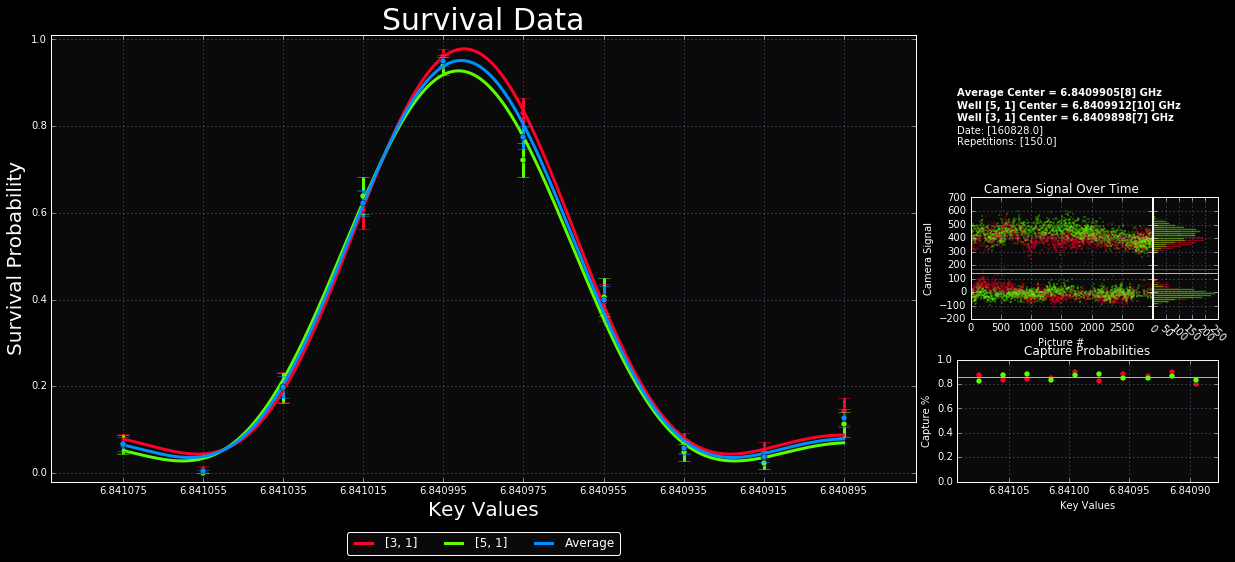

In [13]:
# locals for convenience
filename = "Carrier_Calibration_Top_Vert" # shouldn't include run number.
data = importData(date, filename, 14)
# Atom locations
locs = ['[3, 1]', '[5, 1]']
if True: # All Fitting and Plotting Details 
    # ####################
    # ### fit the data ###
    #
    data['xForFit'] = np.linspace(min(data['Key']), max(data['Key']), 1000)
    centerGuesses = []
    ampGuesses = []
    widthGuess = np.std(data['Key']) / 2
    # Get all the atoms
    for atomInc in range(0, len(locs)):
        centerGuesses.append(data['Key'][data[locs[atomInc]]['Survival Averages'] \
                                         .index(max(data[locs[atomInc]]['Survival Averages']))])
        ampGuesses.append(max(data[locs[atomInc]]['Survival Averages']))
        # def sinc2(x, A, center, scale, offset):
        data[locs[atomInc]]['fitValues'], \
            data[locs[atomInc]]['covValues'] = fit(sinc2, data['Key'], data[locs[atomInc]]['Survival Averages'], 
                                                    p0=[ampGuesses[atomInc], centerGuesses[atomInc], widthGuess, 0.5])
        data[locs[atomInc]]['fitData'] = sinc2(data['xForFit'], *data[locs[atomInc]]['fitValues']);

        # fit the averaged data.
    avgCenterGuess = np.mean(centerGuesses)
    avgAmpGuess = np.mean(ampGuesses)
    data['[Correlation Averages]']['fitValues'], data['[Correlation Averages]']['covValues'] \
        = fit(sinc2, data['Key'], data['[Correlation Averages]']['Total average single atom survival'],
              p0=[0.95, avgCenterGuess, widthGuess, 0.05])
    data['[Correlation Averages]']['fitData'] = sinc2(data['xForFit'], *data['[Correlation Averages]']['fitValues'])                                     

    # ###
    # Plot most standard info
    standardSurvivalPlot(data, locs)

    # ### info plot
    grid1 = mpl.gridspec.GridSpec(12, 16)
    grid1.update(left=0.05, right=0.95, wspace=1.2, hspace=1000)
    infoPlot = plt.subplot(grid1[0:4, 12:16])
    infoPlot.axis("off")
    infoPlot.text(0,0.1,"Repetitions: " + str(data['Repetitions']))
    infoPlot.text(0, 0.2, "Date: " + str(data['Date']))
    for atomInc in range(len(locs)):
        infoPlot.text(0,0.3 + 0.1 * atomInc,'Well ' + locs[atomInc] + ' Center = ' + "{:.7f}".format(data[locs[atomInc]]['fitValues'][1]) + "[" 
                      + "{:.0f}".format(10**7*np.sqrt(data[locs[atomInc]]['covValues'][1][1])) + "] GHz", fontweight='bold')
    infoPlot.text(0,0.3 + 0.1 * len(locs),'Average Center = ' + "{:.7f}".format(data['[Correlation Averages]']['fitValues'][1]) + "[" 
                  + "{:.0f}".format(10**7 * np.sqrt(data['[Correlation Averages]']['covValues'][1][1])) + "] GHz", fontweight='bold');


## Generic Gaussian Fit

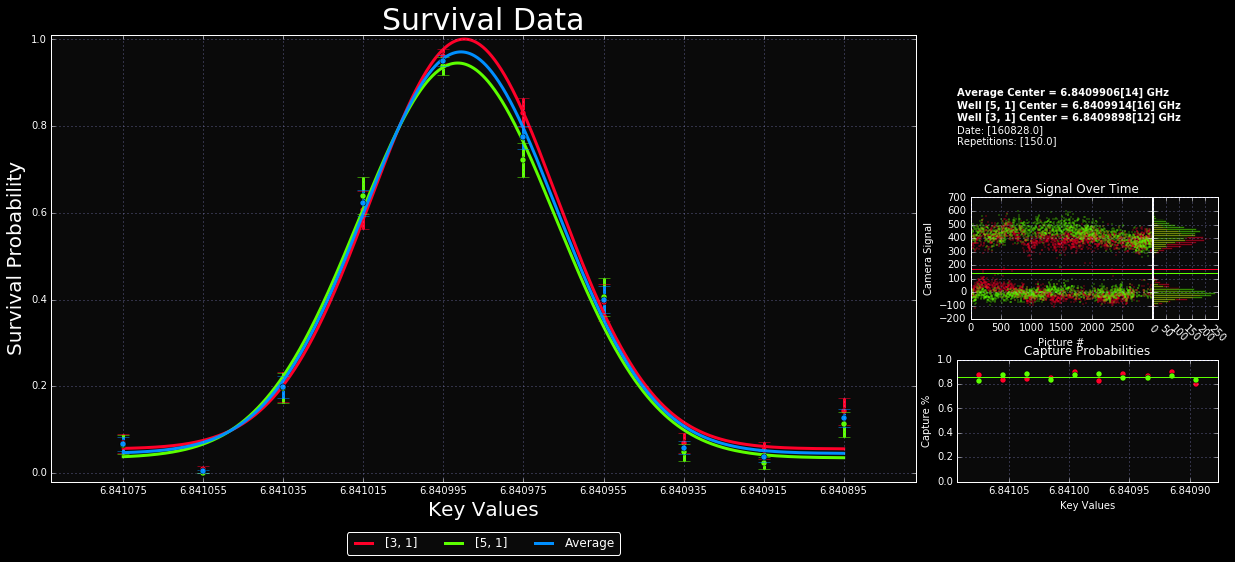

In [14]:
# locals for convenience
filename = "Carrier_Calibration_Top_Vert" # shouldn't include run number.
data = importData(date, filename, 14)
# Atom locations
locs = ['[3, 1]', '[5, 1]']
if True: # All Fitting and Plotting Details 
    # ################
    # ### fit the data ###
    #
    data['xForFit'] = np.linspace(min(data['Key']), max(data['Key']), 1000)
    centerGuesses = []
    widthGuess = np.std(data['Key']) / 2
    # Get all the atoms
    for atomInc in range(0, len(locs)):
        centerGuesses.append(data['Key'][data[locs[atomInc]]['Survival Averages'] \
                                         .index(max(data[locs[atomInc]]['Survival Averages']))])
        # def gaussian(x, A1, x01, sig1, offset)
        data[locs[atomInc]]['fitValues'], \
            data[locs[atomInc]]['covValues'] = fit(gaussian, data['Key'], data[locs[atomInc]]['Survival Averages'], 
                                                    p0=[0.95, centerGuesses[atomInc], widthGuess, 0.05])
        data[locs[atomInc]]['fitData'] = gaussian(data['xForFit'], *data[locs[atomInc]]['fitValues']);
    # fit the averaged data.
    avgCenterGuess = np.mean(centerGuesses)
    data['[Correlation Averages]']['fitValues'], data['[Correlation Averages]']['covValues'] \
        = fit(gaussian, data['Key'], data['[Correlation Averages]']['Total average single atom survival'],
              p0=[0.95, avgCenterGuess, widthGuess, 0.05])
    data['[Correlation Averages]']['fitData'] = gaussian(data['xForFit'], *data['[Correlation Averages]']['fitValues'])                                     

    # ###
    # Plot most standard info
    standardSurvivalPlot(data, locs)

    # ### info plot
    grid1 = mpl.gridspec.GridSpec(12, 16)
    grid1.update(left=0.05, right=0.95, wspace=1.2, hspace=1000)
    infoPlot = plt.subplot(grid1[0:4, 12:16])
    infoPlot.axis("off")
    infoPlot.text(0,0.1,"Repetitions: " + str(data['Repetitions']))
    infoPlot.text(0, 0.2, "Date: " + str(data['Date']))
    for atomInc in range(len(locs)):
        infoPlot.text(0,0.3 + 0.1 * atomInc,'Well ' + locs[atomInc] + ' Center = ' + "{:.7f}".format(data[locs[atomInc]]['fitValues'][1]) + "[" 
                      + "{:.0f}".format(10**7*np.sqrt(data[locs[atomInc]]['covValues'][1][1])) + "] GHz", fontweight='bold')
    infoPlot.text(0,0.3 + 0.1 * len(locs),'Average Center = ' + "{:.7f}".format(data['[Correlation Averages]']['fitValues'][1]) + "[" 
                  + "{:.0f}".format(10**7 * np.sqrt(data['[Correlation Averages]']['covValues'][1][1])) + "] GHz", fontweight='bold');


## Generic Double-Gaussian Fit

In [ ]:
# locals for convenience
filename = "Carrier_Calibration_Top_Vert" # shouldn't include run number.
data = importData(date, filename, 14)
# Atom locations
locs = ['[3, 1]', '[5, 1]']

if True: # All Fitting and Plotting Details 
    # ################
    # ### fit the data ###
    #
    data['xForFit'] = np.linspace(min(data['Key']), max(data['Key']), 1000)
    centerGuesses = [[]]
    widthGuess = np.std(data['Key']) / 4
    # Get all the atoms
    for atomInc in range(0, len(locs)):
        guess1 = data['Key'][data[locs[atomInc]]['Survival Averages'] \
                                         .index(max(data[locs[atomInc]]['Survival Averages']))]
        dataWithoutPoissonian = []
        for dataInc in range(len(data[locs[atomInc]]['Survival Averages'])):
            dataWithoutPoissonian.append(data[locs[atomInc]]['Survival Averages'] 
                                         - poissonian(data['Key'][dataInc], guess1, 
                                                     2 * max(data[locs[atomInc]]['Survival Averages'])
                                                     / poissonian(guess1, guess1, 1)))
        dataWithoutPoissonian = dataWithoutPoissonian[0]
        guess2 = data['Key'][np.argmax(dataWithoutPoissonian)]
        if atomInc == 0:
            centerGuesses = [[guess1, guess2]]
        else:
            centerGuesses.append([guess1, guess2])
        # 
        print(centerGuesses)
        data[locs[atomInc]]['fitValues'], \
            data[locs[atomInc]]['covValues'] = fit(doubleGaussian, data['Key'], data[locs[atomInc]]['Survival Averages'], 
                                                    p0=[0.8, centerGuesses[atomInc][0], widthGuess,
                                                        0.8, centerGuesses[atomInc][0], widthGuess, 0.05])
        data[locs[atomInc]]['fitData'] = doubleGaussian(data['xForFit'], *data[locs[atomInc]]['fitValues']);

    # fit the averaged data.
    avgCenterGuess1 = np.mean(centerGuesses[:][0])
    avgCenterGuess2 = np.mean(centerGuesses[:][1])
    data['[Correlation Averages]']['fitValues'], data['[Correlation Averages]']['covValues'] \
        = fit(doubleGaussian, data['Key'], data['[Correlation Averages]']['Total average single atom survival'],
              p0=[0.8, avgCenterGuess1, widthGuess, 0.8, avgCenterGuess2, widthGuess, 0.05])
    data['[Correlation Averages]']['fitData'] = doubleGaussian(data['xForFit'], 
                                                               *data['[Correlation Averages]']['fitValues'])                                     

    # ###
    # Plot most standard info
    standardSurvivalPlot(data, locs)

    # ### info plot
    grid1 = mpl.gridspec.GridSpec(12, 16)
    grid1.update(left=0.05, right=0.95, wspace=1.2, hspace=1000)
    infoPlot = plt.subplot(grid1[0:4, 12:16])
    infoPlot.axis("off")
    infoPlot.text(0,0.1,"Repetitions: " + str(data['Repetitions']))
    infoPlot.text(0, 0.2, "Date: " + str(data['Date']))
    for atomInc in range(len(locs)):
        infoPlot.text(0,0.3 + 0.1 * atomInc,'Well ' + locs[atomInc] + ' Center = ' + "{:.7f}".format(data[locs[atomInc]]['fitValues'][1]) + "[" 
                      + "{:.0f}".format(10**7*np.sqrt(data[locs[atomInc]]['covValues'][1][1])) + "] GHz", fontweight='bold')
    infoPlot.text(0,0.3 + 0.1 * len(locs),'Average Center = ' + "{:.7f}".format(data['[Correlation Averages]']['fitValues'][1]) + "[" 
                  + "{:.0f}".format(10**7 * np.sqrt(data['[Correlation Averages]']['covValues'][1][1])) + "] GHz", fontweight='bold');


## Generic Triple-Gaussian Fit

C:\Users\Mark\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:604: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


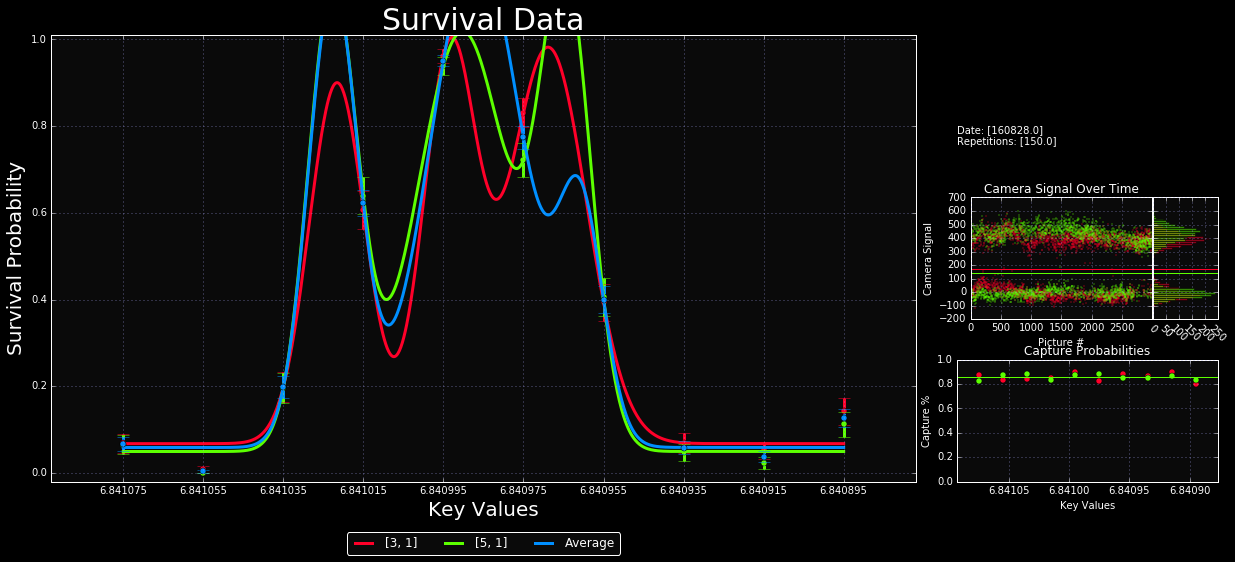

In [15]:
# locals for convenience
filename = "Carrier_Calibration_Top_Vert" # shouldn't include run number.
data = importData(date, filename, 14)
# Atom locations
locs = ['[3, 1]', '[5, 1]']

if True: # All Fitting and Plotting Details 
    # ################
    # ### fit the data ###
    #
    data['xForFit'] = np.linspace(min(data['Key']), max(data['Key']), 1000)
    widthGuess = np.std(data['Key']) / 4
    centerGuesses = np.empty((0, 3), float)
    # Get all the atoms
    for atomInc in range(0, len(locs)):
        guess1 = data['Key'][data[locs[atomInc]]['Survival Averages'] \
                                         .index(max(data[locs[atomInc]]['Survival Averages']))]
        dataWithoutGaussian = []
        for dataInc in range(len(data[locs[atomInc]]['Survival Averages'])):
            # def gaussian(x, A1, x01, sig1, offset)
            dataWithoutGaussian.append(data[locs[atomInc]]['Survival Averages'][dataInc]
                                         - gaussian(data['Key'][dataInc], max(data[locs[atomInc]]['Survival Averages']),
                                                    guess1, widthGuess, 0))
        guess2 = data['Key'][np.argmax(dataWithoutGaussian)]
        # assume that the other peak is on the other side of the biggest peak, and guess that it's spaced similarly.
        centerGuesses = np.append(centerGuesses, [[guess1, guess2, 2 * guess1 - guess2]], axis=0)
        data[locs[atomInc]]['fitValues'], \
            data[locs[atomInc]]['covValues'] = fit(tripleGaussian, data['Key'], data[locs[atomInc]]['Survival Averages'], 
                                                    p0=[0.8, centerGuesses[atomInc][0], widthGuess,
                                                        0.8, centerGuesses[atomInc][1], widthGuess,
                                                        0.8, centerGuesses[atomInc][2], widthGuess, 0.05])
        data[locs[atomInc]]['fitData'] = tripleGaussian(data['xForFit'], *data[locs[atomInc]]['fitValues']);
    # fit the averaged data.
    avgCenterGuesses = []
    avgCenterGuesses.append(np.mean(centerGuesses[:, 0]))
    avgCenterGuesses.append(np.mean(centerGuesses[:, 1]))
    avgCenterGuesses.append(np.mean(centerGuesses[:, 2]))
    data['[Correlation Averages]']['fitValues'], data['[Correlation Averages]']['covValues'] \
        = fit(tripleGaussian, data['Key'], data['[Correlation Averages]']['Total average single atom survival'],
              p0=[0.8, avgCenterGuesses[0], widthGuess,
                  0.8, avgCenterGuesses[1], widthGuess,
                  0.8, avgCenterGuesses[2], widthGuess, 0.05])
    data['[Correlation Averages]']['fitData'] = tripleGaussian(data['xForFit'], 
                                                               *data['[Correlation Averages]']['fitValues'])                                     

    # ###
    # Plot most standard info
    standardSurvivalPlot(data, locs)

    # ### info plot
    grid1 = mpl.gridspec.GridSpec(12, 16)
    grid1.update(left=0.05, right=0.95, wspace=1.2, hspace=1000)
    infoPlot = plt.subplot(grid1[0:4, 12:16])
    infoPlot.axis("off")
    infoPlot.text(0,0.1,"Repetitions: " + str(data['Repetitions']))
    infoPlot.text(0, 0.2, "Date: " + str(data['Date']));

## Generic Lorentzian Fit

C:\Users\Mark\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:604: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


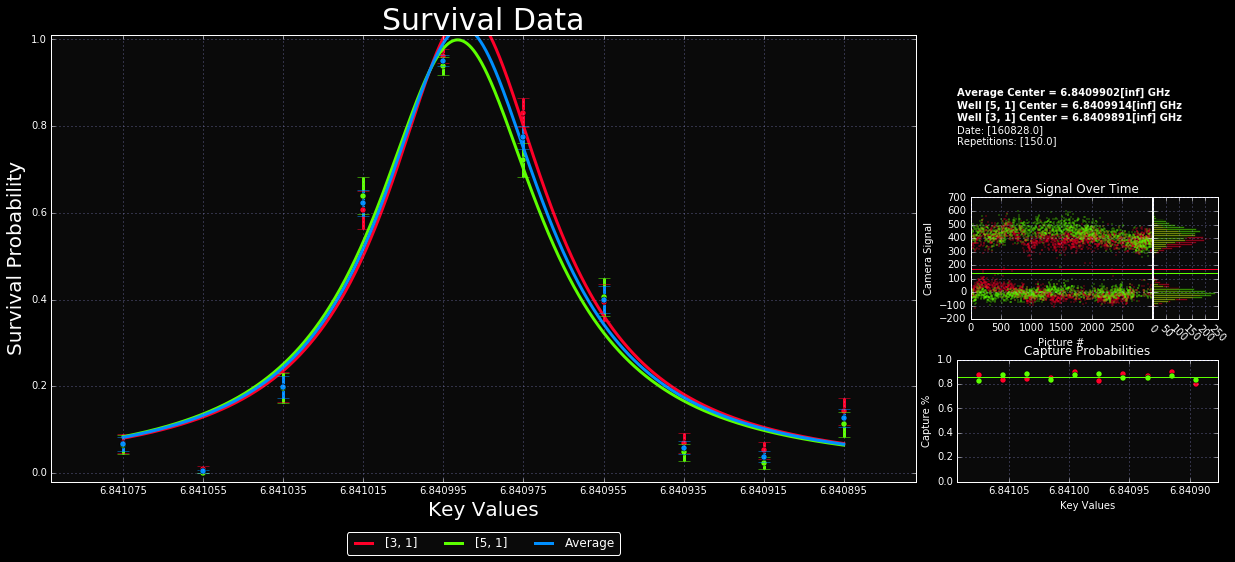

In [16]:
# locals for convenience
filename = "Carrier_Calibration_Top_Vert" # shouldn't include run number.
data = importData(date, filename, 14)
# Atom locations
locs = ['[3, 1]', '[5, 1]']

if True: # All Fitting and Plotting Details 
    # ################ ###
    # ### fit the data ###
    # ################ ###
    data['xForFit'] = np.linspace(min(data['Key']), max(data['Key']), 1000)
    centerGuesses = []
    widthGuess = np.std(data['Key']) / 4 # assumes downward facing.
    # Get all the atoms
    for atomInc in range(0, len(locs)):
        centerGuesses.append(data['Key'][data[locs[atomInc]]['Survival Averages'] \
                                         .index(max(data[locs[atomInc]]['Survival Averages']))])
        data[locs[atomInc]]['fitValues'], \
            data[locs[atomInc]]['covValues'] = fit(lorentzian, data['Key'], data[locs[atomInc]]['Survival Averages'], 
                                                    p0=[0.95, centerGuesses[atomInc], widthGuess, 0.05])
        data[locs[atomInc]]['fitData'] = lorentzian(data['xForFit'], *data[locs[atomInc]]['fitValues'])
    # fit the averaged data.
    avgCenterGuess = np.mean(centerGuesses)
    data['[Correlation Averages]']['fitValues'], data['[Correlation Averages]']['covValues'] \
        = fit(lorentzian, data['Key'], data['[Correlation Averages]']['Total average single atom survival'],
              p0=[0.95, avgCenterGuess, widthGuess, 0.05])
    data['[Correlation Averages]']['fitData'] = lorentzian(data['xForFit'], *data['[Correlation Averages]']['fitValues'])                                     
    # ###
    # Plot most standard info
    standardSurvivalPlot(data, locs)

    # ### info plot
    grid1 = mpl.gridspec.GridSpec(12, 16)
    grid1.update(left=0.05, right=0.95, wspace=1.2, hspace=1000)
    infoPlot = plt.subplot(grid1[0:4, 12:16])
    infoPlot.axis("off")
    infoPlot.text(0,0.1,"Repetitions: " + str(data['Repetitions']))
    infoPlot.text(0, 0.2, "Date: " + str(data['Date']))
    for atomInc in range(len(locs)):
        infoPlot.text(0,0.3 + 0.1 * atomInc,'Well ' + locs[atomInc] + ' Center = ' + "{:.7f}".format(data[locs[atomInc]]['fitValues'][1]) + "[" 
                      + "{:.0f}".format(10**7*np.sqrt(data[locs[atomInc]]['covValues'][1][1])) + "] GHz", fontweight='bold')
    infoPlot.text(0,0.3 + 0.1 * len(locs),'Average Center = ' + "{:.7f}".format(data['[Correlation Averages]']['fitValues'][1]) + "[" 
                  + "{:.0f}".format(10**7 * np.sqrt(data['[Correlation Averages]']['covValues'][1][1])) + "] GHz", fontweight='bold');


## Generic Cos Fit

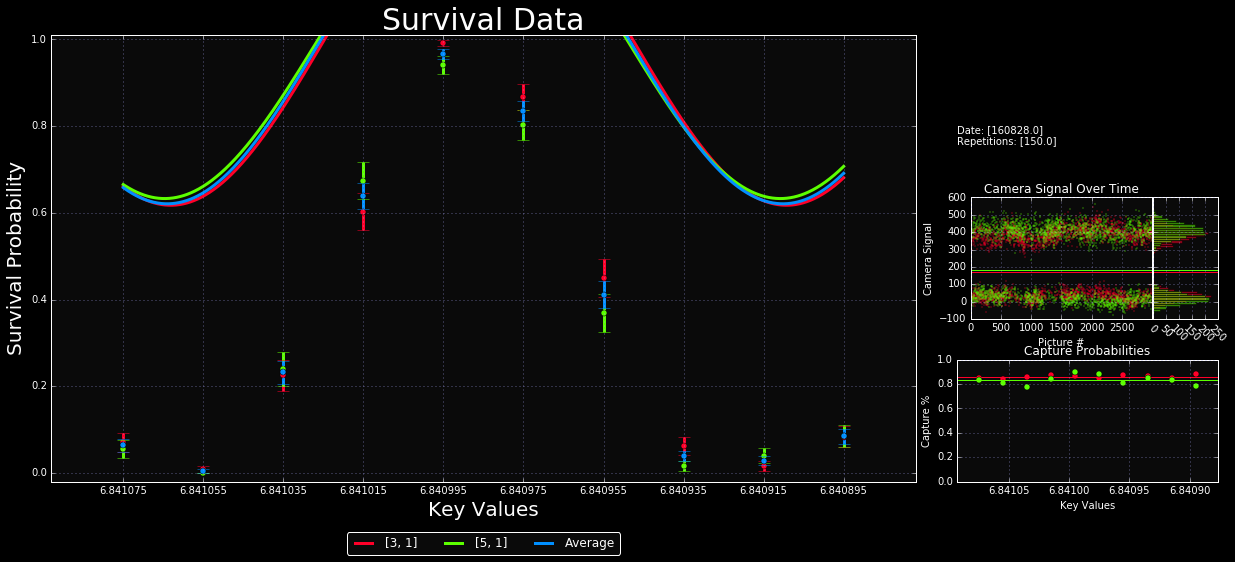

In [23]:
# locals for convenience
filename = "Carrier_Calibration_Top_Vert" # shouldn't include run number.
data = importData(date, filename, 12) # stands for "data from run 11"
locs = ['[3, 1]', '[5, 1]']

if True: # All Fitting and Plotting Details 

    # ################ ###
    # ### fit the data ###
    #
    freqGuess = 6500
    decayGuess = -10000
    offsetGuess = 0.5
    phaseGuess = 2 * np.pi / 3
    data['xForFit'] = np.linspace(min(data['Key']), max(data['Key']), 1000)
    # Get all the atoms
    for atomInc in range(0, len(locs)):
        # def decayingCos(x, A, tau, f, phi, offset):
        ampGuess = max(data[locs[0]]['Survival Averages']) / 2
        data[locs[atomInc]]['fitValues'], \
            data[locs[atomInc]]['covValues'] = fit(decayingCos, data['Key'], data[locs[atomInc]]['Survival Averages'], 
                                                    p0=[ampGuess, decayGuess, freqGuess, phaseGuess, offsetGuess])
        data[locs[atomInc]]['fitData'] = decayingCos(data['xForFit'], *data[locs[atomInc]]['fitValues']);

    # fit the averaged data.
    ampGuess = max(data[locs[0]]['Survival Averages']) / 2
    data['[Correlation Averages]']['fitValues'], data['[Correlation Averages]']['covValues'] \
        = fit(decayingCos, data['Key'], data['[Correlation Averages]']['Total average single atom survival'],
              p0=[ampGuess, decayGuess, freqGuess, phaseGuess, offsetGuess])
    data['[Correlation Averages]']['fitData'] = decayingCos(data['xForFit'], *data['[Correlation Averages]']['fitValues'])                                     
    # ###
    # Plot most standard info
    standardSurvivalPlot(data, locs)

    # ### info plot
    grid1 = mpl.gridspec.GridSpec(12, 16)
    grid1.update(left=0.05, right=0.95, wspace=1.2, hspace=1000)
    infoPlot = plt.subplot(grid1[0:4, 12:16])
    infoPlot.axis("off")
    infoPlot.text(0,0.1,"Repetitions: " + str(data['Repetitions']))
    infoPlot.text(0, 0.2, "Date: " + str(data['Date']));

# Specific Multi-Atom Analysis

## Tunneling Bias Scan

## Tunneling Time Trace

# Specific Single-Atom Data Analysis

## Carrier Calibration

## Microwave Calibration

## Sideband Spectroscopy

## Ramsey Time Trace

## Piezo Scan